# 315 Bird Species - Classification

Dataset found on kaggle: [https://www.kaggle.com/gpiosenka/100-bird-species](https://www.kaggle.com/gpiosenka/100-bird-species)

## Getting the data

We can use the [opendatasets](https://github.com/jovianml/opendatasets) library to download the the dataset from kaggle.

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

od.download('https://www.kaggle.com/gpiosenka/100-bird-species')

Skipping, found downloaded files in "./100-bird-species" (use force=True to force download)


## Importing Libraries

In [3]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
classes_csv = pd.read_csv('/content/100-bird-species/class_dict.csv')
classes_csv

,class_index,class,height,width,scale by
0,0,AFRICAN CROWNED CRANE,128,128,1
1,1,AFRICAN FIREFINCH,128,128,1
2,2,ALBATROSS,128,128,1
3,3,ALEXANDRINE PARAKEET,128,128,1
4,4,AMERICAN AVOCET,128,128,1
...,...,...,...,...,...
310,310,WILSONS BIRD OF PARADISE,128,128,1
311,311,WOOD DUCK,128,128,1
312,312,YELLOW BELLIED FLOWERPECKER,128,128,1
313,313,YELLOW CACIQUE,128,128,1


## Understanding the directory structure

In [5]:
data_dir = './100-bird-species/'

print(f'Directories: {os.listdir(data_dir)}')
classes = os.listdir(data_dir + "/train")
print(f'Number of classes: {len(classes)}')

Directories: ['test', 'EfficientNetB3-birds-98.92.h5', 'valid', 'class_dict.csv', 'train', 'images to test', 'one image to test']
Number of classes: 315


## Defining Transforms

In [6]:
train_tfms = tt.Compose([tt.ToTensor()])   # add more later if required
valid_tfms = tt.Compose([tt.ToTensor()])   # add more later if required

## Converting to PyTorch dataset format

In [7]:
train_ds = ImageFolder(data_dir+'/train', train_tfms) 
valid_ds = ImageFolder(data_dir+'/valid', valid_tfms) 
test_ds = ImageFolder(data_dir+'/test', valid_tfms) 

In [8]:
def dataset_info(dataset):
    print(f'Size fo dataset: {len(dataset)}')
    img, label = dataset[0]
    print(f'Sample-01 Image size: {img.shape}, Label: {label}')
    print(f'Number of classes: {len(dataset.classes)}\n\n')

print('Train Dataset\n-----------')
dataset_info(train_ds)
print('Validation Dataset\n-----------')
dataset_info(valid_ds)
print('Test Dataset\n-----------')
dataset_info(test_ds)

Train Dataset
-----------
Size fo dataset: 45980
Sample-01 Image size: torch.Size([3, 224, 224]), Label: 0
Number of classes: 315


Validation Dataset
-----------
Size fo dataset: 1575
Sample-01 Image size: torch.Size([3, 224, 224]), Label: 0
Number of classes: 315


Test Dataset
-----------
Size fo dataset: 1575
Sample-01 Image size: torch.Size([3, 224, 224]), Label: 0
Number of classes: 315




Each image is a torch tensor of size `3x224x224`

## Viewing the samples

In [9]:
def show_example(img, label):
    print(f'Label: {train_ds.classes[label]} ({label})')
    plt.imshow(img.permute(1, 2, 0))

Label: AMERICAN AVOCET (4)


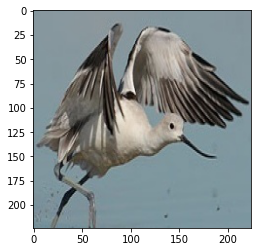

In [10]:
show_example(*train_ds[600])

## Creating Dataloaders
Creating dataloader to load data in batches for training.

In [11]:
batch_size=128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2,   # uses all the cores of the GPU/CPU. A little complex, check out documentation.
                      pin_memory=True)   # for each batch keeps a block of memory allocated(use when in each batch the images are going to be of same size, and each batch will take up exact same size)

valid_dl = DataLoader(valid_ds, 
                    batch_size*2,    # for validation we'll not compute gradients, so we'll need half the memory. Therefore we can double the batch size.
                    num_workers=2, 
                    pin_memory=True)


## Viewing a batch of dataset
We can look at batches of images from the dataset using the `make_grid` method from `torchvision`.

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

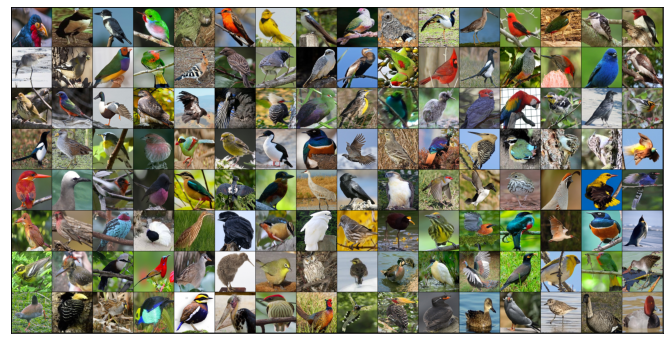

In [13]:
show_batch(train_dl)

## Defining the CNN model

We can define a Base class which will provide us with some helper functions for training and validation. We'll extend this base class to create the Model class.

In [14]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):  
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Now extending this `ClassificationBase` to create the CNN

In [15]:
class WhatBirdie(ClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # input: 3 x 224 x 224
            nn.Conv2d(3, 6, kernel_size=3, padding=1),  # output: 6 x 224 x 224
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #output: 6 x 112 x 112

            nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1),   # output: 12 x 112 x 112
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 12 x 56 x 56

            nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1),  # output: 24 x 56 x 56
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # output: 24 x 28 x 28

            nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),    # output: 24 x 14 x 14

            nn.Conv2d(24, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),    # output: 32 x 7 x 7

            nn.Flatten(),   # takes the output feature map and flattens them into a vector
            nn.Linear(32*7*7, 700),
            nn.ReLU(),
            nn.Linear(700, 700),   
            nn.ReLU(),
            nn.Linear(700, 315)   # 315 classes
        )
        
    def forward(self, xb):
        return self.network(xb)

In [16]:
model = WhatBirdie()
model

WhatBirdie(
  (network): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=1568, out_feat

Verifying that the model works on a batch of training data

In [17]:
# for images, labels in train_dl:
#     print('images.shape:', images.shape)
#     out = model(images)
#     print('out.shape:', out.shape)
#     print('out[0]:', out[0])
#     break

## Moving our dataloader & model to device


In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)    # non-blocking indicates that the tensor will be moved to the GPU in a background thread

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
torch.cuda.empty_cache()

#### Using the above methods to move dataloader & model to device

In [21]:
# Moves the dataloader to GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Moves the model to GPU
#to_device(model, device);

## Training & Validation functions

In [22]:
@torch.no_grad()   
def evaluate(model, val_loader):
    model.eval()    
    outputs = [model.validation_step(batch) for batch in val_loader]    # validation loss & acc for each batch
    return model.validation_epoch_end(outputs)   # mean of validation loss & acc for each batch

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()    
        train_losses = []           # losses for each batch in an epoch
        for batch in train_loader:               # for each batch in the dataloader
            loss = model.training_step(batch)      # calc loss for each batch using the fn we defined earlier
            train_losses.append(loss)
            loss.backward()
            optimizer.step()        # perform gradient descent
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)    # validation loss & acc for that epoch
        result['train_loss'] = torch.stack(train_losses).mean().item()   # mean of training loss that we calculated batchwise
        model.epoch_end(epoch, result)   
        history.append(result)
    return history     # fit fn returns the training history of the model

Before training, let's instantiate model again, on device, and see how it performs on validation set with inital parameters

In [23]:
model = to_device(WhatBirdie(), device)

In [24]:
evaluate(model, valid_dl)

{'val_acc': 0.0027901786379516125, 'val_loss': 5.752139568328857}

## Training Hyperparameters

In [25]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

## Training the Model

In [26]:
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

Epoch [0], train_loss: 5.6051, val_loss: 4.9972, val_acc: 0.0212
Epoch [1], train_loss: 4.5199, val_loss: 3.7230, val_acc: 0.1696
Epoch [2], train_loss: 3.5416, val_loss: 2.9373, val_acc: 0.3144
Epoch [3], train_loss: 2.9236, val_loss: 2.4846, val_acc: 0.3953
Epoch [4], train_loss: 2.4718, val_loss: 2.1491, val_acc: 0.4464
Epoch [5], train_loss: 2.1268, val_loss: 1.9347, val_acc: 0.5140
Epoch [6], train_loss: 1.8310, val_loss: 1.8537, val_acc: 0.5344
Epoch [7], train_loss: 1.5696, val_loss: 1.7500, val_acc: 0.5630
Epoch [8], train_loss: 1.3533, val_loss: 1.8093, val_acc: 0.5638
Epoch [9], train_loss: 1.1642, val_loss: 1.7796, val_acc: 0.5901


## Plot accuracy
Plot validation set accuracy

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

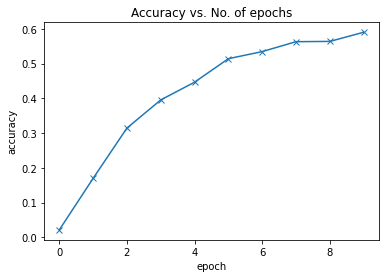

In [28]:
plot_accuracies(history)

Looking at the graph it looks like if we increased the number of epochs, the `val_acc` could have increased further.

## Plot Losses

Plot losses of training & validation set

In [30]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

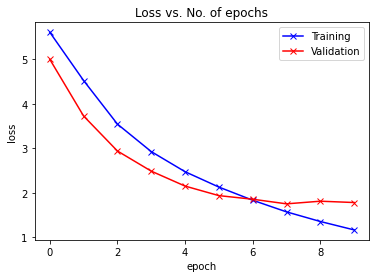

In [31]:
plot_losses(history)

We see that after epoch 8th, the `val_loss` had increased a bit. This shows sign of overfitting. We should add some regularization techniques.

## Testing the model on the whole Test set

In [35]:
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_dl)
val_loss, val_acc = result.values()
print(f'Accuracy: {val_acc*100}%, Loss: {val_loss}')

Accuracy: 59.882956743240356%, Loss: 1.7621179819107056


## Saving the model

In [36]:
torch.save(model.state_dict(), 'WhatBirdies59.pth')